In [14]:
import torch
import torch.nn as nn
import joblib
import anndata as ad
from scipy.stats import ranksums
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class RegressionMLP(nn.Module):
    def __init__(self,):
        super().__init__()
        # Example architecture: 1280 -> 512 -> 256 -> 128 -> 1
        self.model = nn.Sequential(
            nn.Linear(1280, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [3]:
model_baseline_mean_path = '../../data/models/baselines/mean_pear_corr_min_max.joblib'
model_baseline_linreg_path = '../../data/models/baselines/linreg_raw-pear_corr_min_max.joblib'
model_mlp_path = '../../data/models/mlp/pear_corr_min_max_mlp.pt'

anndata_path = '../../data/downstream/scl_mixed_hard.h5ad'

In [4]:
adata = ad.read_h5ad(anndata_path)
adata

AnnData object with n_obs × n_vars = 331 × 1280
    obs: 'pred_value', 'real_value', 'groups'

In [5]:
mlp = torch.load(model_mlp_path, weights_only=False)
mlp.eval()

input_data = torch.from_numpy(adata.X)

with torch.no_grad():
    predictions = mlp(input_data)

adata.obs["mlp_score"] = predictions

In [6]:
baseline_linreg = joblib.load(model_baseline_linreg_path)

input_data = adata.X

predictions = baseline_linreg.predict(input_data)

adata.obs["baseline_linreg_score"] = predictions

In [7]:
baseline_mean = joblib.load(model_baseline_mean_path)

input_data = adata.X

predictions = baseline_mean.predict(input_data)

adata.obs["baseline_mean_score"] = predictions

In [8]:
# Correlation between baseline mean not computable, as their is no variance in predictions

In [9]:
adata.obs

,pred_value,real_value,groups,mlp_score,baseline_linreg_score,baseline_mean_score
seq_id,,,,,,
Sequence11181,Endoplasmic_reticulum,Endoplasmic_reticulum,True,0.562837,0.661524,0.605534
Sequence11182,Cell_membrane,Extracellular,False,0.563066,0.532199,0.605534
Sequence11183,Cytoplasm,Cytoplasm,True,0.557363,0.570492,0.605534
Sequence11184,Cytoplasm,Cytoplasm,True,0.602049,0.611836,0.605534
Sequence11185,Nucleus,Nucleus,True,0.563487,0.621545,0.605534
...,...,...,...,...,...,...
Sequence11512,Nucleus,Nucleus,True,0.627954,0.640472,0.605534
Sequence11513,Nucleus,Nucleus,True,0.606802,0.587197,0.605534
Sequence11514,Extracellular,Cytoplasm,False,0.698001,0.711198,0.605534


In [10]:
print(ranksums(adata.obs.mlp_score[adata.obs.groups], adata.obs.mlp_score[~adata.obs.groups]))
print(ranksums(adata.obs.baseline_linreg_score[adata.obs.groups], adata.obs.baseline_linreg_score[~adata.obs.groups]))

RanksumsResult(statistic=-2.6534580928113654, pvalue=0.00796716630646722)
RanksumsResult(statistic=-1.3131849860118385, pvalue=0.1891206219092444)


Text(0, 0.5, 'Predicted Reliability Score')

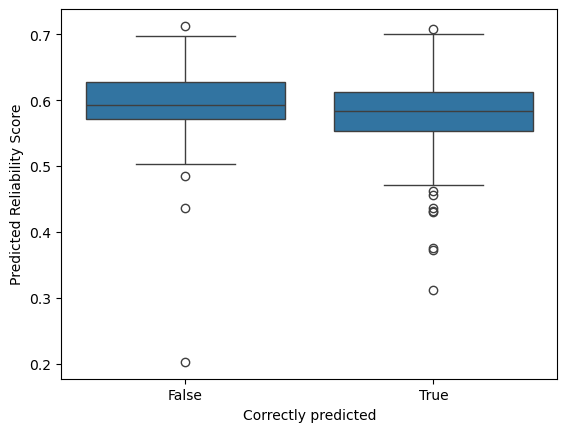

In [17]:
sns.boxplot(x="groups", y="mlp_score", data=adata.obs)
plt.xlabel("Correctly predicted")
plt.ylabel("Predicted Reliability Score")